In [1]:
import numpy as np
import pandas
import pickle
import matplotlib.pyplot as plt

In [2]:
data = np.array(pickle.load(open('../testing_scripts/gym_states.pkl', 'rb')))

In [3]:
states, rewards = [], []
for d in data: 
    states.append(d[0])
    rewards.append(d[1])
    
states = np.array(states)
rewards = np.array(rewards)

In [4]:
states.max(axis=0)

array([0.99999981, 0.99797941, 7.7426992 ])

(array([ 3., 12., 10.,  8., 10., 11., 13., 16., 23., 94.]),
 array([-16.04039999, -14.44083684, -12.8412737 , -11.24171055,
         -9.6421474 ,  -8.04258426,  -6.44302111,  -4.84345796,
         -3.24389482,  -1.64433167,  -0.04476852]),
 <a list of 10 Patch objects>)

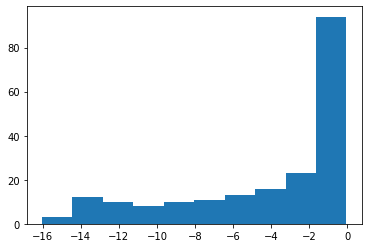

In [5]:
plt.hist(rewards)

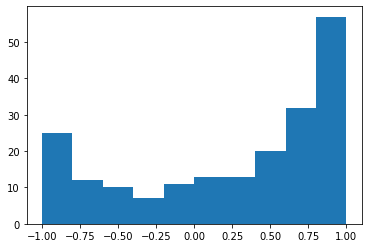

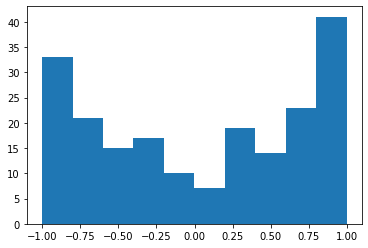

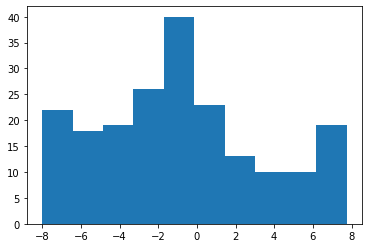

In [6]:


for i in range(3):
    plt.hist(states[:,i])
    plt.show()

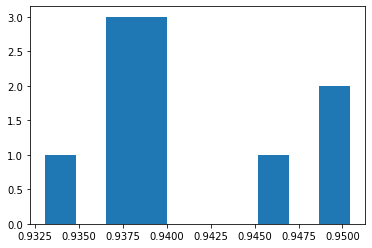

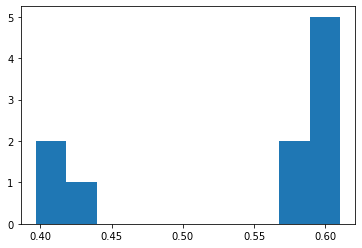

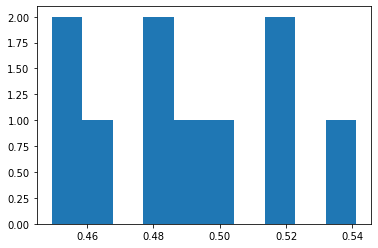

In [66]:
# plotting by different reward bins
mask = np.logical_and(rewards < 0.0 , rewards > -0.1)
for i in range(3):
    plt.hist(states[mask,i])
    plt.show()

In [70]:
# need to scale all states to between 0 and 1. 

states[:,0] = (states[:,0]+1)/2.1
states[:,1] = (states[:,1]+1)/2.1
states[:,2] = (states[:,2]+8.1)/16.1

In [71]:
for i in range(3):
    print(states[:,i].max(), states[:,i].min())


tensor(0.9297) tensor(0.4762)
tensor(0.9292) tensor(0.4762)
tensor(0.5642) tensor(0.5035)


## Fit a neural network to the distribution

In [95]:
import torch
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim
class RewardModel(nn.Module):
    def __init__(self, node_size, act_fn="relu"):
        super().__init__()
        self.act_fn = getattr(torch, act_fn)
        self.fc_1 = nn.Linear(1, node_size)
        self.fc_2 = nn.Linear(node_size, node_size)
        num_states = 3
        num_gaussians = 2
        self.fc_3 = nn.Linear(node_size, 3*num_states*num_gaussians)

    def forward(self, reward):
        out = self.act_fn(self.fc_1(reward))
        out = self.act_fn(self.fc_2(out))
        reward = self.fc_3(out)
        return reward

In [96]:
inputs = torch.Tensor(rewards).unsqueeze(1)#[:20]
states = torch.Tensor(states)#[:20]

In [97]:
model = RewardModel(10)
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [98]:
torch.log_softmax()

TypeError: log_softmax() missing 2 required positional argument: "input", "dim"

epoch 0 loss is: 0.34322986006736755
first series of outputs, then states tensor([0.9532, 0.8589, 0.7230, 1.1066, 0.8697, 0.9079],
       grad_fn=<SelectBackward>) tensor([0.9504, 0.4330, 0.4555]) tensor([-0.0448])
epoch 10 loss is: -0.4432399868965149
first series of outputs, then states tensor([1.1556, 0.9369, 0.8358, 0.8237, 0.8198, 0.9807],
       grad_fn=<SelectBackward>) tensor([0.9504, 0.4330, 0.4555]) tensor([-0.0448])
epoch 20 loss is: -0.7591578960418701
first series of outputs, then states tensor([1.6403, 1.0367, 1.0183, 0.5306, 1.0870, 1.3011],
       grad_fn=<SelectBackward>) tensor([0.9504, 0.4330, 0.4555]) tensor([-0.0448])
epoch 30 loss is: -0.9899880290031433
first series of outputs, then states tensor([2.9356, 1.4230, 1.6464, 0.4032, 1.5870, 2.0060],
       grad_fn=<SelectBackward>) tensor([0.9504, 0.4330, 0.4555]) tensor([-0.0448])
epoch 40 loss is: -1.2705761194229126
first series of outputs, then states tensor([5.9978, 1.8052, 3.5091, 0.5794, 1.7778, 3.6257],
     

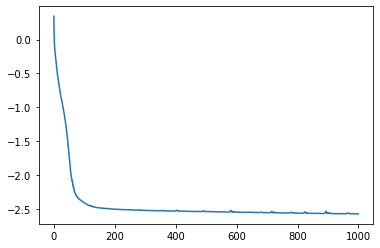

In [47]:

num_epochs = 1000
losses = []
for epoch in range(num_epochs):  # loop over the dataset multiple times

    # zero the parameter gradients
    optimizer.zero_grad()

    # forward + backward + optimize
    outputs = model(inputs)
    
    logpi = outputs[:,:]
    mus = outputs[:,3:6]
    logsigmas = outputs[:,6:]
    
    probs = torch.log_softmax(logpi, dim=-1)

    #outputs = outputs.exp() 
    #loss = - torch.distributions.Beta(outputs[:,0:3], outputs[:,3:] ).log_prob(states) # criterion(outputs, labels)
    
    loss = loss.sum(-1).mean()
    #print( 'loss for epoch', loss.item())
    loss.backward()
    optimizer.step()
    
    losses.append(loss.item())

    # print statistics
    if epoch %10 ==0:
        print('epoch', epoch, 'loss is:', loss.item())
        print('first series of outputs, then states', outputs[0], states[0], inputs[0])

print('Finished Training')
plt.plot(losses)

In [88]:
test_rewards = [-8, -6, -4, -2, -0.01, -0.04]
res = model(torch.Tensor(test_rewards).unsqueeze(1)).exp()
print(res)

tensor([[1.8772e+00, 4.8934e-01, 6.5368e-01, 5.0964e+00, 5.1643e-01, 8.3427e-01],
        [3.6625e+00, 3.8565e-01, 9.3062e-01, 5.6002e+00, 4.5606e-01, 1.1694e+00],
        [7.1458e+00, 3.0393e-01, 1.3249e+00, 6.1538e+00, 4.0275e-01, 1.6391e+00],
        [1.6236e+01, 4.7950e-01, 3.7041e+00, 6.7204e+00, 5.1542e-01, 4.3341e+00],
        [1.7585e+03, 9.3418e+00, 1.2786e+02, 9.6953e+01, 1.0059e+01, 1.3739e+02],
        [1.5364e+03, 8.4445e+00, 1.1611e+02, 9.1848e+01, 9.0170e+00, 1.2335e+02]],
       grad_fn=<ExpBackward>)


In [89]:
torch.distributions.Beta(res[:,:3],res[:,3:] ).sample([1])

tensor([[[1.6300e-01, 9.9894e-01, 6.0861e-01],
         [4.5801e-01, 9.9889e-01, 3.4246e-01],
         [5.6751e-01, 8.0271e-04, 5.6236e-01],
         [7.6333e-01, 3.0160e-01, 4.7210e-01],
         [9.4124e-01, 5.9337e-01, 4.6149e-01],
         [9.4954e-01, 4.5786e-01, 4.6576e-01]]])

test reward is: -8
torch.Size([1000, 3])


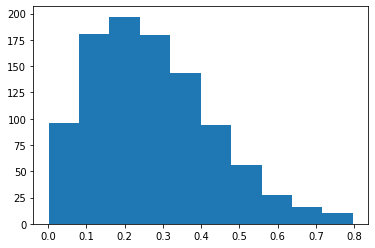

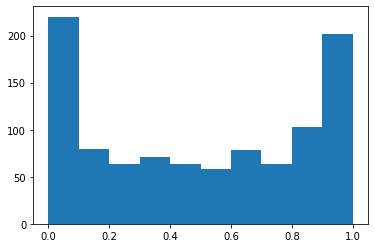

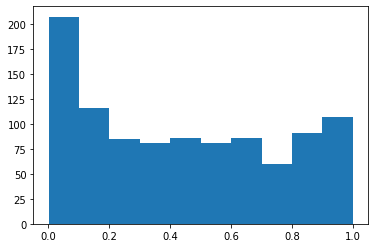

test reward is: -6
torch.Size([1000, 3])


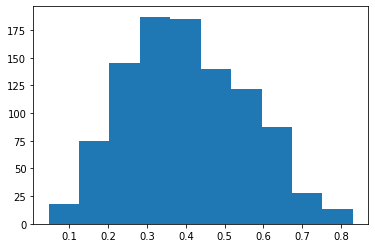

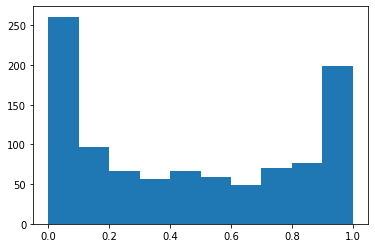

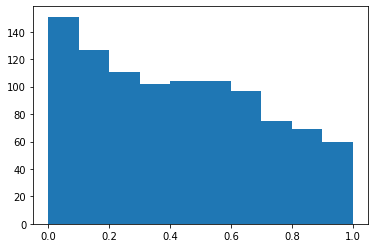

test reward is: -4
torch.Size([1000, 3])


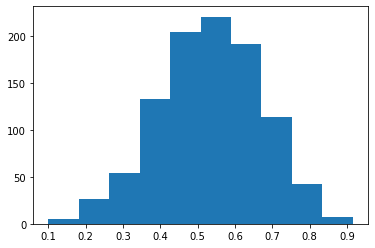

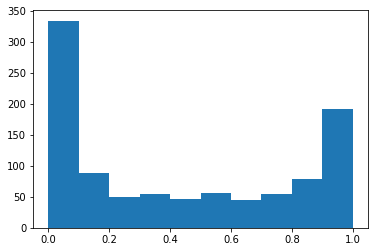

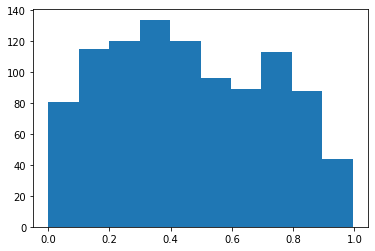

test reward is: -2
torch.Size([1000, 3])


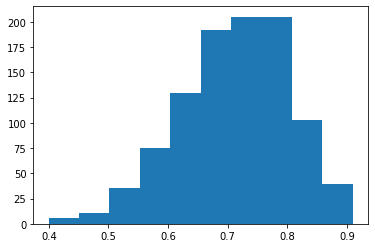

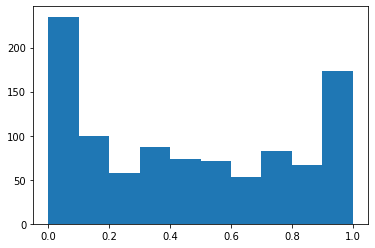

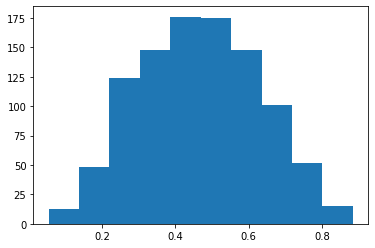

test reward is: -0.01
torch.Size([1000, 3])


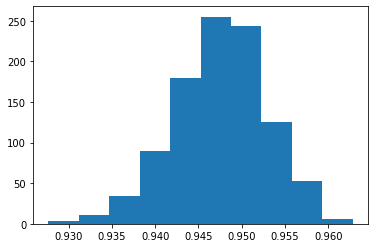

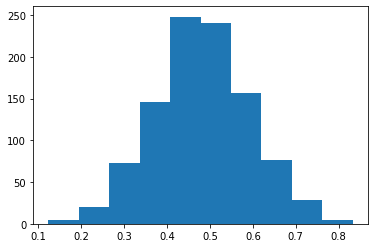

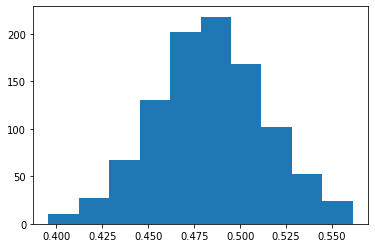

test reward is: -0.04
torch.Size([1000, 3])


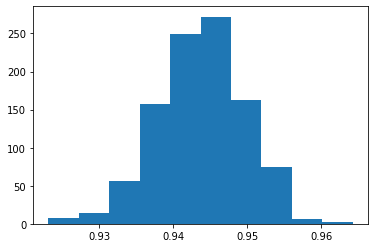

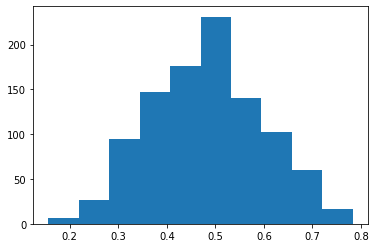

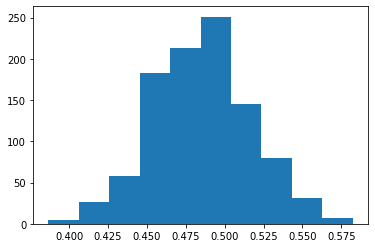

In [90]:
for r in range(6):
    print('test reward is:',test_rewards[r])
    samps = torch.distributions.Beta(res[r,:3],res[r,3:] ).sample([1000])
    print(samps.shape)
    for i in range(3):
        plt.hist(samps[:,i])
        plt.show()
    print('=========')

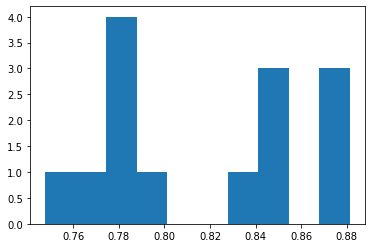

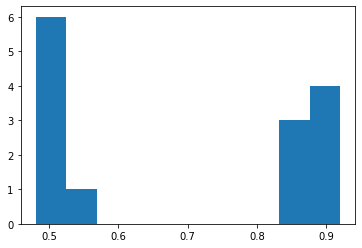

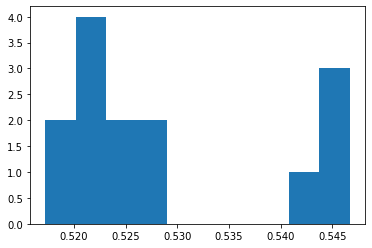

In [94]:
# plotting by different reward bins
mask = np.logical_and(rewards < -1.5 , rewards > -2.3)
for i in range(3):
    plt.hist(states[mask,i])
    plt.show()

# multivariate with covariance matrix

In [26]:
np.expand_dims(rewards,1).shape

(200, 1)

In [27]:
states.shape

torch.Size([200, 3])

In [28]:
sr = np.concatenate([states,np.expand_dims(rewards,1)], axis=1)

In [29]:
mus = sr.mean(axis=0)
mus

array([ 0.25759256,  0.04116807, -0.85134329, -4.13237383])

In [30]:
sr[:,-1].argmax()

0

In [33]:
sr[100:105]

array([[ 0.69378781, -0.72017944, -2.79928017, -1.0322417 ],
       [ 0.55697513, -0.83052921, -3.51992369, -1.43155908],
       [ 0.3608104 , -0.93263918, -4.43205023, -2.20321623],
       [ 0.1265475 , -0.99196053, -4.84497976, -3.4119423 ],
       [-0.15194434, -0.98838907, -5.58845758, -4.43225475]])

In [42]:
sr[-5:]

array([[ -0.85682186,   0.51561255,   6.57430579,  -8.92827924],
       [ -0.98122235,   0.19288003,   6.9525191 , -11.08147816],
       [ -0.98537324,  -0.17041005,   7.30684485, -13.5234398 ],
       [ -0.86792712,  -0.49669156,   6.97073859, -14.16388703],
       [ -0.65559451,  -0.75511313,   6.72087891, -11.73367566]])

In [32]:
sigmas = np.cov(sr, rowvar=False)
sigmas

array([[ 4.48933624e-01, -9.01084850e-04,  1.36170822e-01,
         2.84404396e+00],
       [-9.01084850e-04,  4.87700815e-01,  4.38566898e-03,
        -1.23406532e-01],
       [ 1.36170822e-01,  4.38566898e-03,  1.80887414e+01,
         1.23868889e+00],
       [ 2.84404396e+00, -1.23406532e-01,  1.23868889e+00,
         2.06164720e+01]])

In [36]:
import torch
torch.distributions.MultivariateNormal(torch.Tensor(mus),torch.Tensor(sigmas) ).sample()

tensor([ 0.1935,  0.0999,  3.9036, -5.1785])

## Independent

array([0.11866389, 0.53043727, 2.26055126])

In [34]:
torch.distributions.Normal(torch.Tensor(mus),torch.Tensor(states.std(axis=0)) ).sample()

tensor([-0.8570, -0.6774, -0.3861])